### My Commits

EfficientNet Training B5 : https://www.kaggle.com/jagadish13/efficientnetb5-model-training/output

### Commit 1
- Gaussian Noise 0.2
- Dropout 0.385
- EffNet B5 (Fold: 0, Epoch: 62/100, GAP: 0.1453)
- Dropout 0.385

**LB -6.8042**

### Commit 2
- Gaussian Noise 0.25
- Dropout 0.385
- EffNet B5 (Fold: 0, Epoch: 62/100, GAP: 0.1453)
- Dropout 0.385

### Commit 3 (Effnet B7)
- Gaussian Noise 0.2
- Dropout 0.385
- EffNet B5 (Fold: 1, Epoch: 36/100, GAP: 1.1026)
- 628x628
- Dropout 0.385

**LB -6.8174**

### Commit 4 (Effnet B5)
- Gaussian Noise 0.2
- Dropout 0.385
- EffNet B5 (Fold: 0, Epoch: 75/100, GAP: 0.1453)

EffNet(-6.9229) + Quantile + Elastic Net(-6.9073)

### Commit 4 (Effnet B5)
- Gaussian Noise 0.2
- Dropout 0.385
- EffNet B5 (Fold: 0, Epoch: 75/100, GAP: 0.1453)

EffNet (0.1) + Quantile(0.7) + (0.2)Elastic Net(-6.9073)

### Commit 7
- Gaussian Noise 0.2
- Dropout 0.385
- EffNet B5 (Fold: 0, Epoch: 75/100, GAP: 0.1453)

EffNet + Quantile + Elastic Net(-6.9073) + Lasso Regressor

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=cffcc87e19dcdf3bf168215a29ef672b26479ca7418f24f322fbd9fd025bee9b
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=07b863709886dfdcf8163be03f5480769f0432f32b5e74463cdbc58ce4971d7d
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

In [3]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
seed_everything(42)

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [6]:
Dropout_model = 0.5
FVC_weight = 0.2
Confidence_weight = 0.2

In [7]:
commits_df = pd.DataFrame(columns = ['commit_num', 'FVC_weight', 'Dropout_model', 'LB_score', 'seed'])

In [8]:
# Seed
commits_df['seed'] = 42
commits_df.loc[commits_df['commit_num'] == 23, 'seed'] = 0

In [9]:
commits_df

,commit_num,FVC_weight,Dropout_model,LB_score,seed


## 3. Download data, auxiliary functions and model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [10]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [11]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'Male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [12]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [13]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [14]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [15]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    model.load_weights('../input/efficientnetb5model-training-comp-score/fold-4.h5')
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [16]:
tr_p, vl_p = train_test_split(P, shuffle=True, train_size = 0.8) 

In [17]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [18]:
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

6.752804172040673
6.752823645723581
6.752830966329654
6.75283583015215
6.752839275322852
6.75284297789232
6.752846537679177
6.7528498305137
6.75285520981973



## 4. Prediction and submission <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

## 4.1 Average prediction <a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [19]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [20]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3087.004405,137.191260
1,ID00421637202311550012437_-12,2841.332605,184.377896
2,ID00422637202311677017371_-12,1998.432161,145.104654
3,ID00423637202312137826377_-12,3404.191121,189.450024
4,ID00426637202313170790466_-12,2969.408454,116.233422


In [21]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [22]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

## 4.2 Osic-Multiple-Quantile-Regression <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [23]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [24]:
import math
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])



In [25]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [26]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [27]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [28]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [29]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [30]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [31]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [32]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

## 4.3 The change of mloss <a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [33]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
def new_asy_qloss(y_true,y_pred):
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    epsilon = 0.8
  
    v = tf.maximum( -(1-q)*(e+q*epsilon), q*(e-(1-q)*epsilon))
    v1 = tf.maximum(v,0.0)
    return K.mean(v1)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * new_asy_qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [34]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [35]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [36]:
NFOLD = 10 # originally 5
kf = KFold(n_splits=NFOLD)

In [37]:
%%time
cnt = 0
EPOCHS = 855
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [32.79851531982422, 6.466818332672119]
val [40.339908599853516, 6.6435394287109375]
predict val...
predict test...
FOLD 2
train [32.16485595703125, 6.4603495597839355]
val [39.30967330932617, 6.726011276245117]
predict val...
predict test...
FOLD 3
train [34.13157272338867, 6.517062187194824]
val [40.36484909057617, 6.668117523193359]
predict val...
predict test...
FOLD 4
train [34.98910903930664, 6.526129245758057]
val [32.661888122558594, 6.51960563659668]
predict val...
predict test...
FOLD 5
train [32.3819580078125, 6.4460062980651855]
val [47.875946044921875, 6.854011535644531]
predict val...
predict test...
FOLD 6
train [33.815040588378906, 6.487556457519531]
val [41.134822845458984, 6.567305564880371]
predict val...
predict test...
FOLD 7
train [33.73027801513672, 6.501952648162842]
val [31.9573974609375, 6.583372116088867]
predict val...
predict test...
FOLD 8
train [34.710906982421875, 6.5293121337890625]
val [34.428585052490234, 6.520720958709717]
predict val...


In [38]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

137.82310794991858 236.1353344647038


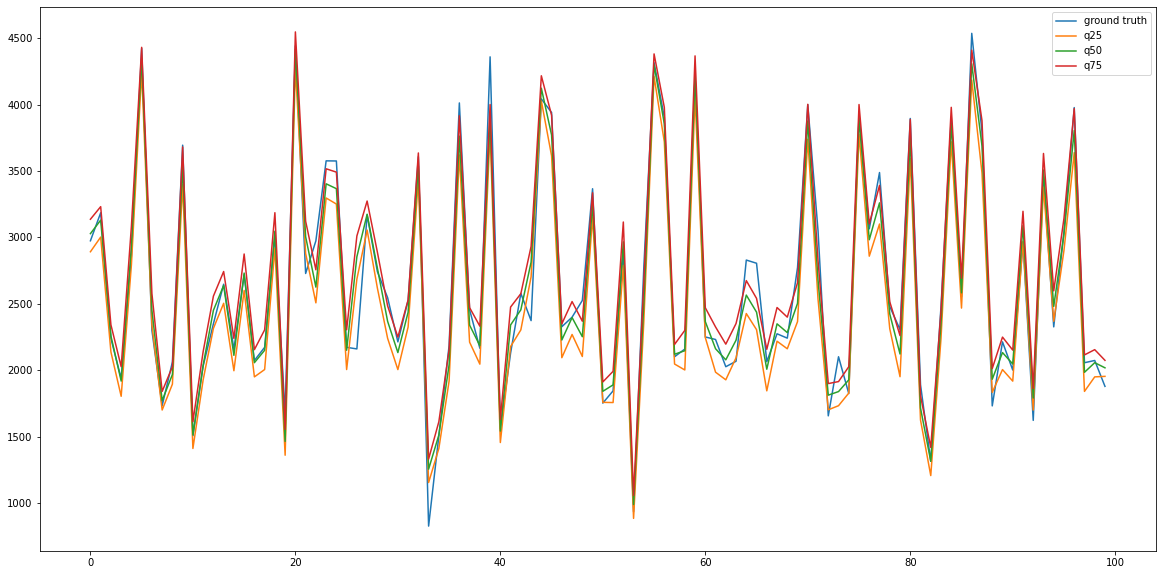

In [39]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.figure(figsize = (20,10))
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [40]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

61.09326171875 236.1353344647038 460.164794921875 1.0


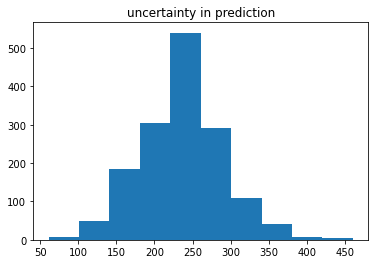

In [41]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [42]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [43]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2872.916870,231.260742
1541,ID00419637202311204720264_-11,3020,100.0,2870.713989,232.832947
1542,ID00419637202311204720264_-10,3020,100.0,2868.348083,234.425446
1543,ID00419637202311204720264_-9,3020,100.0,2865.982239,236.017792
1544,ID00419637202311204720264_-8,3020,100.0,2863.616364,237.610352
1545,ID00419637202311204720264_-7,3020,100.0,2861.250580,239.202820
1546,ID00419637202311204720264_-6,3020,100.0,2858.884827,240.795319
1547,ID00419637202311204720264_-5,3020,100.0,2856.518890,242.387604
1548,ID00419637202311204720264_-4,3020,100.0,2854.175110,243.978333
1549,ID00419637202311204720264_-3,3020,100.0,2851.842346,245.567932


In [44]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [45]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2872.916870,231.260742,2872.916870,231.260742
1541,ID00419637202311204720264_-11,2870.713989,232.832947,2870.713989,232.832947
1542,ID00419637202311204720264_-10,2868.348083,234.425446,2868.348083,234.425446
1543,ID00419637202311204720264_-9,2865.982239,236.017792,2865.982239,236.017792
1544,ID00419637202311204720264_-8,2863.616364,237.610352,2863.616364,237.610352


In [46]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2644.070282,331.377393,1936.817291,2576.114719,2693.865570,2830.804199,3214.998627
Confidence,730.0,301.891939,62.777569,167.082336,252.008453,303.962288,355.561714,415.153015
FVC1,730.0,2644.070282,331.377393,1936.817291,2576.114719,2693.865570,2830.804199,3214.998627
Confidence1,730.0,301.891939,62.777569,167.082336,252.008453,303.962288,355.561714,415.153015


In [47]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [48]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [49]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

## 4.4 Elastic Net

In [50]:
import os
import numpy as np
import pandas as pd
import random
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
import category_encoders as ce

from sklearn.linear_model import Ridge, ElasticNet
from functools import partial
import scipy as sp

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px


In [51]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [52]:
OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42 
seed_everything(seed=SEED)

N_FOLD = 10

In [53]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_a = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [54]:
train = pd.concat([train, test_a])

output = pd.DataFrame()

gb = train.groupby('Patient') # Combines all col data by object name and return mean values respectively

# tqdm => i love you so much in spanish, progress bar for running loops

tk0 = tqdm(gb, total = len(gb))

for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby("Weeks"):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Age': 'base_Age'}
        
        tmp = tmp.rename(columns = rename_cols)
        
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent'] 
        
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        
        # Concat the empty DF with edited DF
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
        
train = output[output['Week_passed']!=0].reset_index(drop=True)



In [55]:
output

,Patient,predict_Week,FVC,base_Week,base_FVC,Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,-4,2315,-4,2315,58.253649,79,Male,Ex-smoker,0
1,ID00007637202177411956430,5,2214,-4,2315,58.253649,79,Male,Ex-smoker,9
2,ID00007637202177411956430,7,2061,-4,2315,58.253649,79,Male,Ex-smoker,11
3,ID00007637202177411956430,9,2144,-4,2315,58.253649,79,Male,Ex-smoker,13
4,ID00007637202177411956430,11,2069,-4,2315,58.253649,79,Male,Ex-smoker,15
...,...,...,...,...,...,...,...,...,...,...
5,ID00426637202313170790466,19,2978,59,2774,68.117081,73,Male,Never smoked,-40
6,ID00426637202313170790466,31,2908,59,2774,68.117081,73,Male,Never smoked,-28
7,ID00426637202313170790466,43,2975,59,2774,68.117081,73,Male,Never smoked,-16
8,ID00426637202313170790466,59,2774,59,2774,68.117081,73,Male,Never smoked,0


In [56]:
# Testing Input Construction

test = test_a.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Age': 'base_Age'})

# Adding Sample Submission
submission = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/sample_submission.csv")

# In submisison file, format: ID_'week', using lambda to split the ID
submission['Patient'] = submission['Patient_Week'].apply(lambda x:x.split('_')[0])

# In submisison file, format: ID_'week', using lambda to split the Week
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x:x.split('_')[1]).astype(int)

test = submission.drop(columns = ["FVC", "Confidence"]).merge(test, on = 'Patient')

test['Week_passed'] = test['predict_Week'] - test['base_Week']

test.set_index('Patient_Week', inplace=True)

In [57]:
folds = train[['Patient', TARGET]].copy()
folds = train[['Patient', TARGET]].copy()
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

### Model Building

In [58]:
def run_single_model(clf, train_df, test_df, folds, features, target, fold_num=0):
    trn_idx = folds[folds.fold!=fold_num].index
    val_idx = folds[folds.fold==fold_num].index
    
    y_tr = target.iloc[trn_idx].values
    X_tr = train_df.iloc[trn_idx][features].values
    y_val = target.iloc[val_idx].values
    X_val = train_df.iloc[val_idx][features].values
    
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    clf.fit(X_tr, y_tr)
    
    oof[val_idx] = clf.predict(X_val)
    predictions += clf.predict(test_df[features])
    return oof, predictions

In [59]:
def run_kfold_model(clf, train, test, folds, features, target, n_fold=9):
    
    # n_fold from 5 to 7
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):

        _oof, _predictions = run_single_model(clf,train, test, folds, features, target, fold_num = fold_)

        oof += _oof
        predictions += _predictions/n_fold
    
    return oof, predictions

In [60]:
target = train[TARGET]
test[TARGET] = np.nan # Displays all Null values

# features
cat_features = ['Sex', 'SmokingStatus'] # Categorical Features
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)] # Numerical Features

features = num_features + cat_features
drop_features = [TARGET, 'predict_Week', 'Percent', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)

In [61]:
for alpha1 in [0.3]:
    for l1s in [0.8]:
        
        print(" For alpha:",alpha1,"& l1_ratio:",l1s)
        clf = ElasticNet(alpha=alpha1, l1_ratio = l1s)
        oof, predictions = run_kfold_model(clf, train, test, folds, features, target, n_fold=N_FOLD)

        train['FVC_pred'] = oof
        test['FVC_pred'] = predictions

        # baseline score
        train['Confidence'] = 100
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)

        def loss_func(weight, row):
            confidence = weight
            sigma_clipped = max(confidence, 70)
            diff = abs(row['FVC'] - row['FVC_pred'])
            delta = min(diff, 1000)
            score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
            return -score

        results = []
        tk0 = tqdm(train.iterrows(), total=len(train))
        for _, row in tk0:
            loss_partial = partial(loss_func, row=row)
            weight = [100]
            result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
            x = result['x']
            results.append(x[0])

        # optimized score
        train['Confidence'] = results
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)

 For alpha: 0.3 & l1_ratio: 0.8
-7.136575746463419



-6.338293513101472


In [62]:
TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

oof, predictions = run_kfold_model(clf, train, test, folds, features, target, n_fold=N_FOLD)

In [63]:
train['Confidence'] = oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-6.732727315800078


In [64]:
test['Confidence'] = predictions
test = test.reset_index()

In [65]:
sub = submission[['Patient_Week']].merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], on='Patient_Week')
sub = sub.rename(columns={'FVC_pred': 'FVC'})

for i in range(len(test_a)):
    sub.loc[sub['Patient_Week']==test_a.Patient[i]+'_'+str(test_a.Weeks[i]), 'FVC'] = test_a.FVC[i]
    sub.loc[sub['Patient_Week']==test_a.Patient[i]+'_'+str(test_a.Weeks[i]), 'Confidence'] = 0.1
    
sub[sub.Confidence<1]

sub.to_csv('submission.csv', index=False, float_format='%.1f')

In [66]:
elastic_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [67]:
elastic_sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3076.939961,220.639212
1,ID00421637202311550012437_-12,2846.914090,217.967356
2,ID00422637202311677017371_-12,2039.217394,195.474611
3,ID00423637202312137826377_-12,3380.401692,224.620169
4,ID00426637202313170790466_-12,2964.968775,236.675604
...,...,...,...
725,ID00419637202311204720264_133,2523.676541,226.683809
726,ID00421637202311550012437_133,2293.650670,224.011953
727,ID00422637202311677017371_133,1485.953974,201.519208
728,ID00423637202312137826377_133,2827.138272,230.664766


## 4.5 Lasso Regressor

In [68]:


import os
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from functools import partial

import numpy as np
import pandas as pd
import random
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error , mean_absolute_error
import category_encoders as ce

from PIL import Image
import cv2
import pydicom

import torch

#from ngboost import NGBRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")



def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    


OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 10




train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()




# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train.head()

# construct test input

test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')\
        .rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
print(test.shape)
test.head()


submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
print(submission.shape)
submission.head()



folds = train[[ID, 'Patient', TARGET]].copy()
#Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.head()



#===========================================================
# model 
#===========================================================
def run_single_lasso(param, train_df, test_df, folds, features, target, fold_num=0):
    
    trn_idx = folds[folds.fold!=fold_num].index
    val_idx = folds[folds.fold==fold_num].index
    
    y_tr = target.iloc[trn_idx].values
    X_tr = train_df.iloc[trn_idx][features].values
    y_val = target.iloc[val_idx].values
    X_val = train_df.iloc[val_idx][features].values
    
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    
    clf = Lasso(**param )
    clf.fit(X_tr, y_tr)
    
    oof[val_idx] = clf.predict(X_val)
    predictions += clf.predict(test_df[features])

    logger.info("fold{} score: {:<8.5f}"
                .format(fold_num, np.sqrt(mean_absolute_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions


def run_kfold_lasso(param, train, test, folds, features, target, n_fold=5):
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        
        logger.info("Fold {}".format(fold_))
        _oof, _predictions = run_single_lasso(param, 
                                                    train, 
                                                    test,
                                                    folds,  
                                                    features,
                                                    target, 
                                                    fold_num=fold_)
        oof += _oof
        predictions += _predictions/n_fold
    
    logger.info("CV score: {:<8.5f}"
                .format(np.sqrt(mean_absolute_error(target, oof))))
    
    return oof, predictions


target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
        
xgb_param = {
                    'random_state': SEED,
                    }

oof, predictions = run_kfold_lasso(xgb_param, train, test, folds, features, target, n_fold=N_FOLD)



train['FVC_pred'] = oof
test['FVC_pred'] = predictions



# baseline score
train['Confidence'] = 100
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)




import scipy as sp

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(train.iterrows(), total=len(train))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    #bounds = [(70, 100)]
    #result = sp.optimize.minimize(loss_partial, weight, method='SLSQP', bounds=bounds)
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])


    


# optimized score
train['Confidence'] = results
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)



TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

ridge_param = {  'random_state': SEED,
                    }

oof, predictions = run_kfold_lasso(ridge_param, train, test, folds, features, target, n_fold=N_FOLD)

train['Confidence'] = oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)


def lb_metric(train):
    train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
    train['diff'] = abs(train['FVC'] - train['FVC_pred'])
    train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
    train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
    score = train['score'].mean()
    return score





score = lb_metric(train)
logger.info(f'Local Score: {score}')



test['Confidence'] = predictions

submission.head()

sub4 = submission.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub4.columns = submission.columns
sub4.to_csv('submission_lasso.csv', index=False)
sub4.head()

(1549, 8)


Fold 0
fold0 score: 11.73833
Fold 1
fold1 score: 14.41432
Fold 2
fold2 score: 11.94142
Fold 3
fold3 score: 11.95163
Fold 4
fold4 score: 12.91850
Fold 5
fold5 score: 12.62612
Fold 6
fold6 score: 13.49130
Fold 7



(12144, 11)
(730, 10)
(730, 3)


fold7 score: 11.87524
Fold 8
fold8 score: 11.50869
Fold 9
fold9 score: 12.00273
CV score: 12.47756


-7.128967725330719


Fold 0
fold0 score: 11.36345
Fold 1
fold1 score: 14.49672
Fold 2
fold2 score: 12.24852
Fold 3
fold3 score: 12.24924
Fold 4
fold4 score: 12.70263
Fold 5
fold5 score: 12.01968
Fold 6
fold6 score: 12.92354
Fold 7
fold7 score: 11.30992
Fold 8
fold8 score: 11.85067
Fold 9



-6.336353354646507


fold9 score: 11.71756
CV score: 12.31715
Local Score: -6.737557190268827


-6.737557190268827


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3096.587242,211.543959
1,ID00421637202311550012437_-12,2832.301227,222.465083
2,ID00422637202311677017371_-12,2009.390807,209.774085
3,ID00423637202312137826377_-12,3393.760652,215.995469
4,ID00426637202313170790466_-12,2982.717917,234.989140


In [69]:
lasso_sub = sub4[["Patient_Week","FVC","Confidence"]].copy()

lasso_sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3096.587242,211.543959
1,ID00421637202311550012437_-12,2832.301227,222.465083
2,ID00422637202311677017371_-12,2009.390807,209.774085
3,ID00423637202312137826377_-12,3393.760652,215.995469
4,ID00426637202313170790466_-12,2982.717917,234.989140
...,...,...,...
725,ID00419637202311204720264_133,2548.532522,221.388870
726,ID00421637202311550012437_133,2284.246507,232.309994
727,ID00422637202311677017371_133,1461.336086,219.618996
728,ID00423637202312137826377_133,2845.705932,225.840380


## 4.6 Ensemble and blending <a class="anchor" id="4.4"></a>

[Back to Table of Contents](#0.1)

In [70]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df3 = elastic_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df4 = lasso_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [71]:
df = df1[['Patient_Week']].copy()
df['FVC'] = 0.25*df1['FVC'] +  0.44*df2['FVC'] + 0.18*df3['FVC'] + 0.13 * df4['FVC']
df['Confidence'] = 0.25*df1['Confidence'] + 0.44*df2['Confidence'] + 0.18*df3['Confidence'] + 0.13*df4['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2957.717751,200.905200
1,ID00419637202311204720264_-10,2986.012221,202.832211
2,ID00419637202311204720264_-11,2989.162005,203.045798
3,ID00419637202311204720264_-12,2992.240058,203.268314
4,ID00419637202311204720264_-2,2960.852966,201.120036


In [72]:
df.to_csv('submission.csv', index=False)

## Hoping for the Best